## 1. Carga de datos e importación de librerías

In [63]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn

from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestRegressor, IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, Normalizer
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer, PolynomialFeatures

from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

#TODO Introducir el dataset con el que se vaya a trabajar
df = pd.read_csv('iris_null.csv')
df.head()



,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## 2. Exploración del dataset

In [15]:
print('Shape: ', df.shape)
#Obtenemos información sobre el tipo de dato y los nulos por columna
df.info()


Shape:  (150, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   144 non-null    float64
 2   petal_length  149 non-null    float64
 3   petal_width   149 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [3]:
cuenta_clases = df.groupby('species').size()
cuenta_clases

species
setosa        50
versicolor    50
virginica     50
dtype: int64

## 3. Visualización del dataset 
1. Realizar un histplot para tener una noción general.
2. Realizar un gráfico controlando los categóricos, después los exploraremos en mayor porfundida (sns.countplot())
3. Realizar un heatmap para ver correlaciones.
4. Realizar un scatterpolot para explorar las correlaciones vistas.
5. Utiliza boxplot para ver la dispersión de los datos y detectar Outliers.

array([[<Axes: title={'center': 'sepal_length'}>,
        <Axes: title={'center': 'sepal_width'}>],
       [<Axes: title={'center': 'petal_length'}>,
        <Axes: title={'center': 'petal_width'}>]], dtype=object)

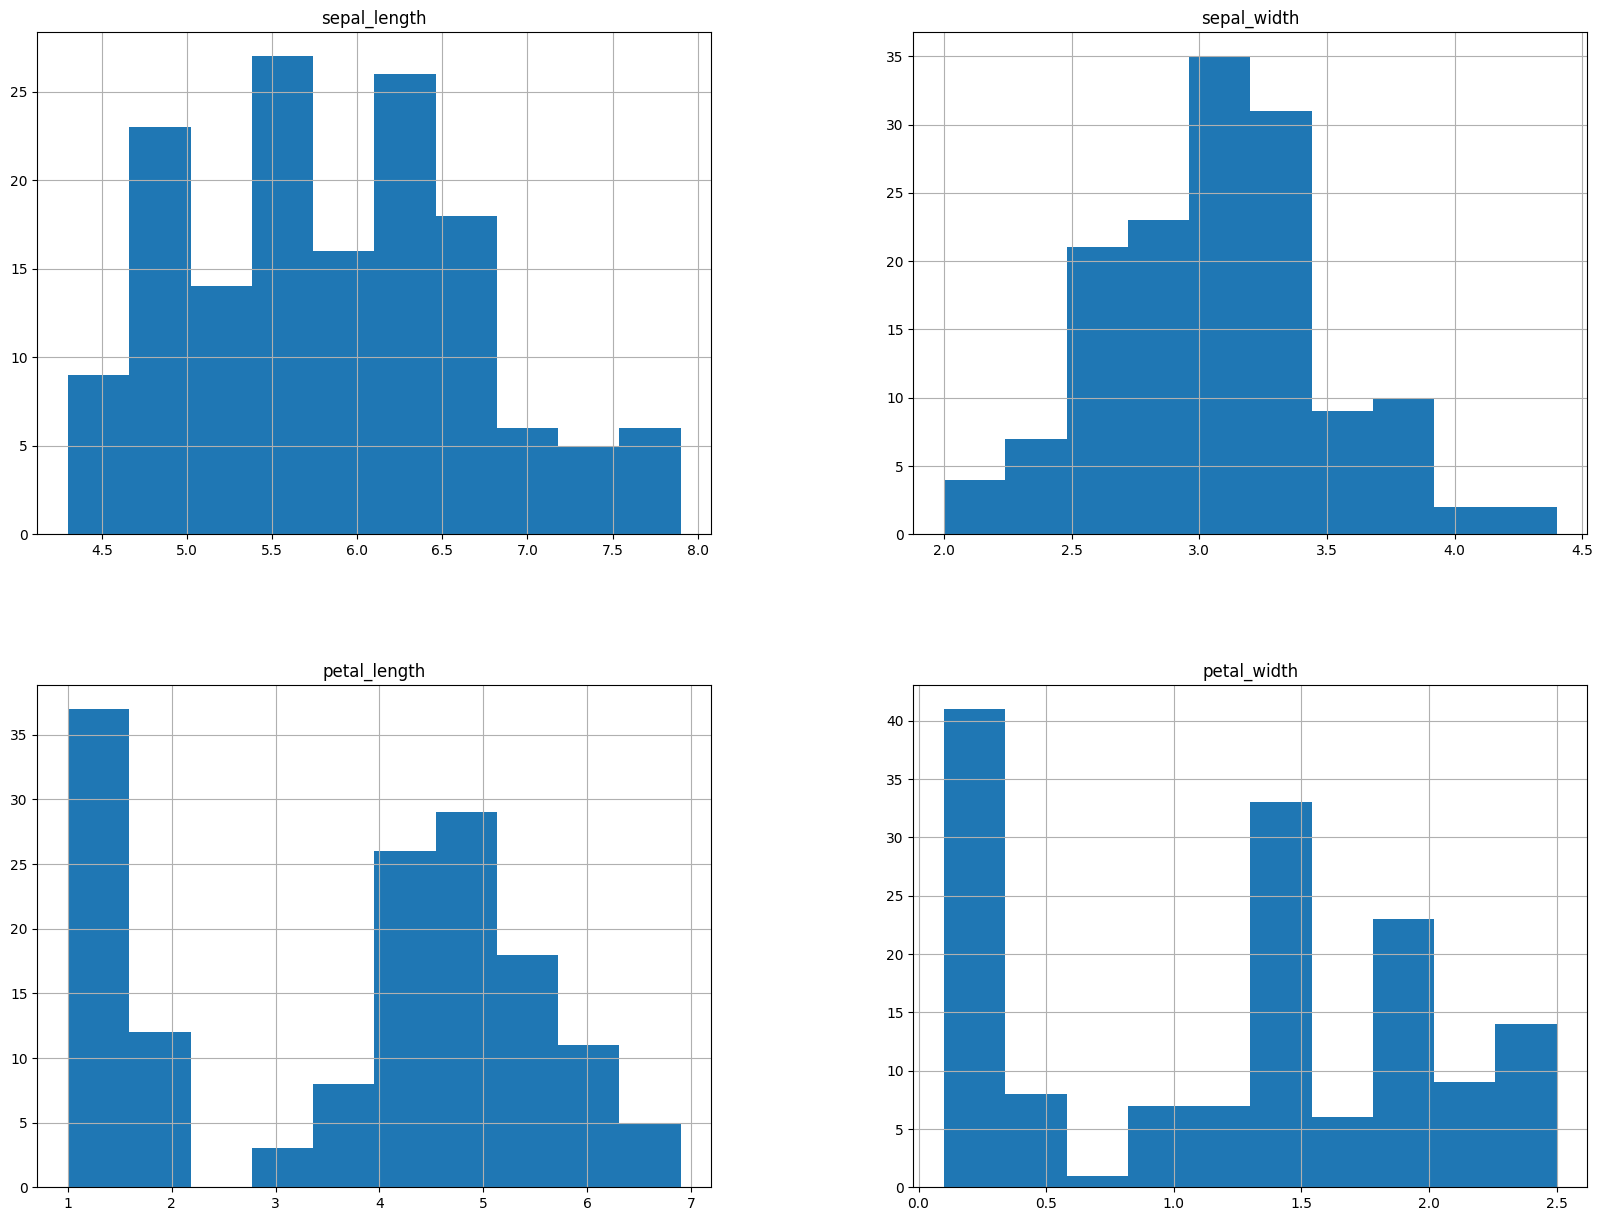

In [3]:
df.hist(bins=10, figsize=(20, 15))

### Exploración de los categóricos

Valores ÚNICOS: ['setosa' 'versicolor' 'virginica']


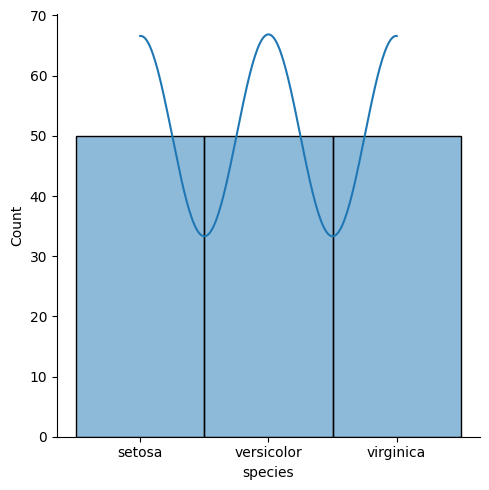

In [6]:
#TODO Introducir el nombre de la columna que se va a predecir

print('Valores ÚNICOS:', df['species'].unique())
#sns.countplot(df['species'])
sns.displot(df['species'], kde=True)

### Exploración de correlaciones

<Axes: >

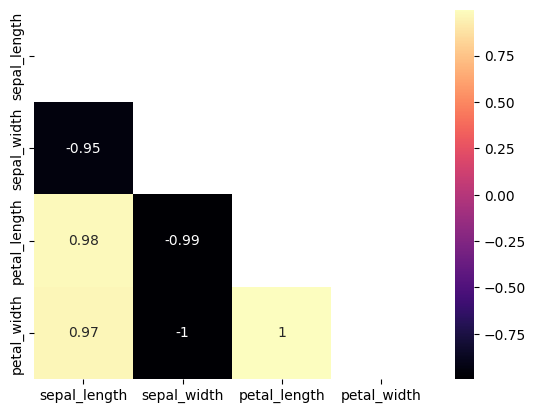

In [4]:
df_corr = df.corr(numeric_only=True)
filter = np.triu(df_corr)
sns.heatmap(df_corr.corr(), annot=True, cmap='magma' , mask=filter)

### Scatterplot para profundizar en las correlaciones

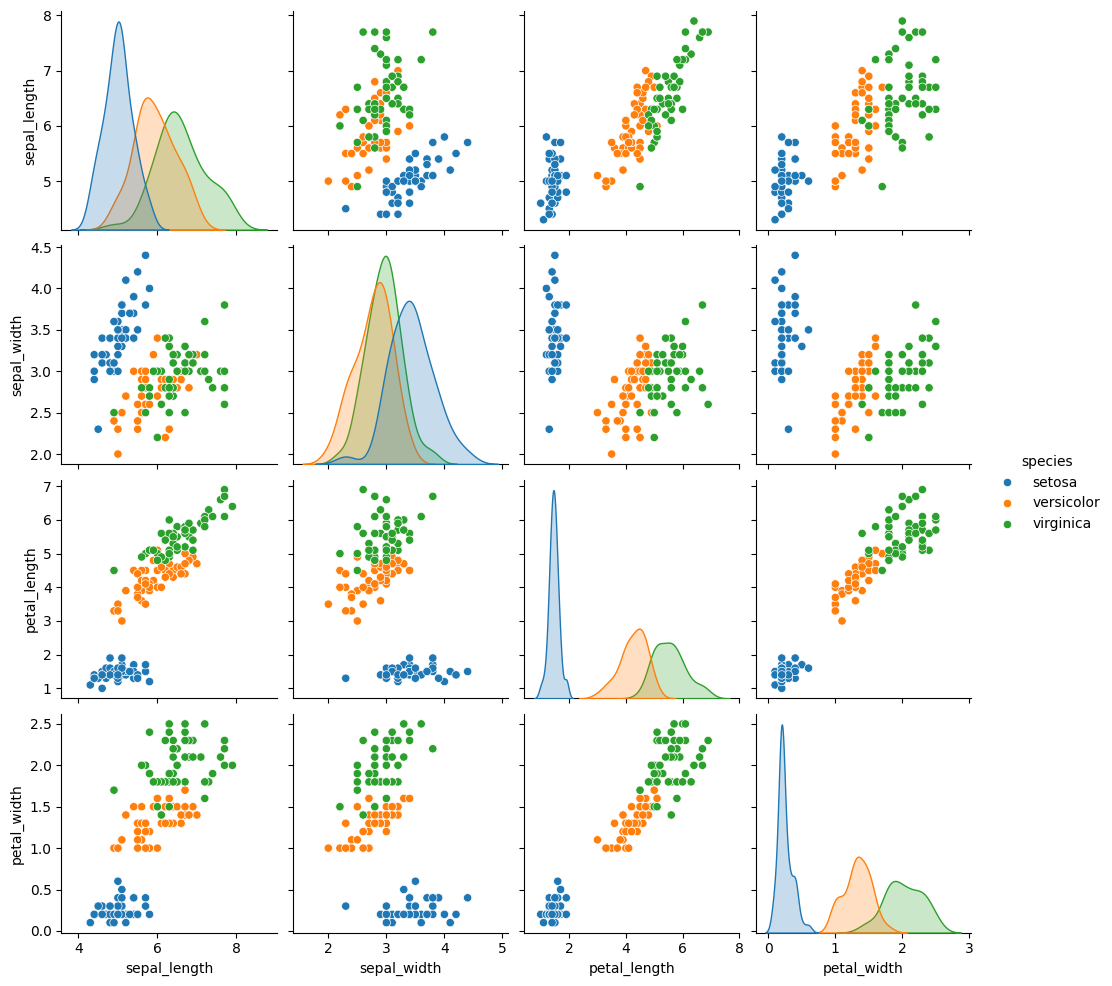

In [5]:
# TODO Introducir el nombre de las columnas que se van a utilizar para predecir, añadir una categórica en hue

# SI NECESITAS VER UNA RELACIÓN MUY CONCRETA UTILIZA ESTE OTRO:
#sns.scatterplot(data=df, x='sepal_length', y='sepal_width', hue='species')

#Para ver todas las relaciones posibles
sns.pairplot(df, hue='species')

### Boxplot: distribución de datos y detección de Outliers

<Axes: >

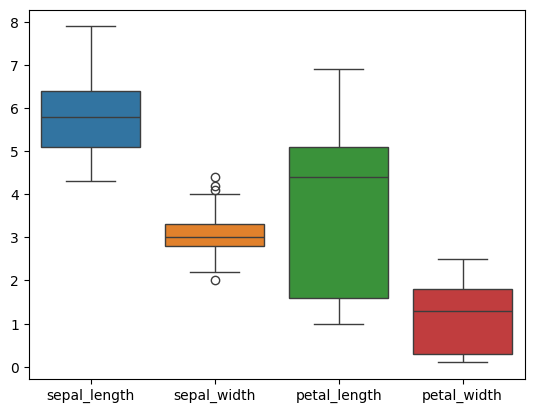

In [6]:
#boxplot de una columna con categoría
#sns.boxplot(data=df, x='species', y='sepal_length')

#Boxplot de todas las columnas
sns.boxplot(data=df)

## 4. Preparación de las métricas de validación

In [23]:
#Eliminamos temporalmente los NAN y los valores no numéricos.

df_dropnan = df.dropna()

X_dropnan = df_dropnan.drop(['species'], axis=1)
y_dropnan = df_dropnan['species']
y_numerical = LabelEncoder().fit_transform(y_dropnan)



In [13]:

#TODO PARA PROBLEMAS DE CLASIFICACIÓN (FALTA LA MATRIZ DE CONFUSIÓN)

def calc_classification_predictions(X, y):
    """
    Accuracy: ¿cuántos acierta?
    Precision : ¿Está detectando todos los positivos o deja alguno fuera?
    Recall o sensibilidad: ¿de todos los positivos, cuántos son positivos de verdad? (está colando muchos falsos positivos?)
    F1-score: ¿Puedo combinar Precision y Recall en una sola métrica?
    """
    df_results = pd.DataFrame(columns=['model_name', 'accuracy', 'recall', 'f1_score', 'overall_f1_score'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    models = [
        LogisticRegression(max_iter=1000),
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(kernel='rbf', C=100, gamma=0.1), 
    ]

    for model in models:
        # entrenamiento y predicciones
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # classification metrics
        model_name = model.__class__.__name__
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        overall_f1 = f1_score(y_test, y_pred, average='weighted')

        # guardar resultados
        row = [model_name, accuracy, recall, f1, overall_f1]
        df_results.loc[len(df_results)] = row

    return df_results

calc_classification_predictions(X_dropnan, y_numerical)


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,0.944444,0.933333,0.939153,0.943342
1,KNeighborsClassifier,0.916667,0.900000,0.906694,0.913624
2,DecisionTreeClassifier,0.944444,0.941026,0.941026,0.944444
3,RandomForestClassifier,0.972222,0.966667,0.970110,0.972006
4,SVC,0.916667,0.900000,0.906694,0.913624


## 5. Preprocesado de datos
1. Tratar valores faltantes o nulos.
2. Transformación de categóricos a numéricos (OrdinalEncoder-entrada // LabelEncoder-salida)
3. Tratar Outliers -si procede.

4. Escalar datos (estandarizar o normalizar)
5. Reducir dimensionalidad del dataset (eliminacion de features SelectKBest)

6. Creación de nuevas features significativas.
7. Discretización de datos -binarizar o kbins.
8. Corregir desbalanceo de datos y sesgos.

### Tratar valores faltantes

Comprobamos dónde están los valroes faltantes dentro del dataframe. Opcionalmente, podríamos utilizar df.info() si quisiéramos saber cuántos registros tienen valores para cada columna. 

In [14]:
df.isnull().sum()

sepal_length    0
sepal_width     6
petal_length    1
petal_width     1
species         0
dtype: int64

In [15]:

#TODO Renombramos la salida con 'target'

df_rename = df.rename(columns={'species': 'target'})
df_rename.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   144 non-null    float64
 2   petal_length  149 non-null    float64
 3   petal_width   149 non-null    float64
 4   target        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [16]:


#TODO Elegir el tipo de IMPUTER que se va a utilizar
df_imputed = df_rename.copy()

#imputer = SimpleImputer(strategy='median')
#imputer = KNNImputer()
imputer = IterativeImputer()

#TODO Cambiar el nombre por el de la columna que se va a imputar + tipo de imputado (df_simple_sepal_width, o df_iterative_sepal_width)
df_imputed_sepal_width = pd.DataFrame(df_imputed['sepal_width'])
imputer.fit(df_imputed_sepal_width)
df_imputed['sepal_width'] = imputer.transform(df_imputed_sepal_width)
df_imputed['sepal_width'] = df_imputed['sepal_width'].astype('float64')


df_imputed_petal_length = pd.DataFrame(df_imputed['petal_length'])
imputer.fit(df_imputed_petal_length)
df_imputed['petal_length'] = imputer.transform(df_imputed_petal_length)
df_imputed['petal_length'] = df_imputed['petal_length'].astype('float64')

df_imputed_petal_width = pd.DataFrame(df_imputed['petal_width'])
imputer.fit(df_imputed_petal_width)
df_imputed['petal_width'] = imputer.transform(df_imputed_petal_width)
df_imputed['petal_width'] = df_imputed['petal_width'].astype('float64')


df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [17]:
#COMPROBACIÓN DE MÉTRICAS DE EVALUACIÓN

X = df_imputed.drop(['target'], axis=1)
y = LabelEncoder().fit_transform(df_imputed['target'])

calc_classification_predictions(X,y)

,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.0,1.0,1.0,1.0
1,KNeighborsClassifier,1.0,1.0,1.0,1.0
2,DecisionTreeClassifier,1.0,1.0,1.0,1.0
3,RandomForestClassifier,1.0,1.0,1.0,1.0
4,SVC,1.0,1.0,1.0,1.0


### Convertir categóricos a numéricos

Puesto que algunos métodos para tratar Outliers son sensibles a los categóricos, vamos a proceder a convertirlos en numéricos ahora. Disponemos de los siguientes métodos:

-get_dummies : método genérico de pandas. Sobredimensiona el df con demasiadas columnas. No recomendable.

-LabelEncoder : clase de ScikitLearn para datos de salida.

-OrdinalEncoder: clase de scikitLearn para datos de entrada.

In [18]:
#EJEMPLO DE ORDINAL ENCODER PARA UNA COLUMNA DE ENTRADA
""""
        # Identificar las columnas categóricas y numéricas
columnas_categoricas = ['tamaño_categorico']
columnas_numericas = ['edad', 'ingreso']

        # Separar las columnas categóricas y numéricas
X_categorico = df[columnas_categoricas]
X_numerico = df[columnas_numericas]

        # Transformar las columnas categóricas
ordinal_encoder = OrdinalEncoder()
X_categorico_encoded = ordinal_encoder.fit_transform(X_categorico)

        # CREAR UN NUEVO DATAFRAME CON LA TRANSFORMACIÓN DE LAS CATEGÓRICAS!!!
X_categorico_encoded_df = pd.DataFrame(X_categorico_encoded, columns=columnas_categoricas)

        # CONCATENAMOS NUESTRAS NUMÉRICAS ORIGINALES CON LAS QUE HEMOS TRANSFORMADO HACE UN SEGUNDO
X_final = pd.concat([X_numerico, X_categorico_encoded_df], axis=1)

"""

df_2 = df_imputed.copy()
df_2['target'] = LabelEncoder().fit_transform(df_2['target'])

X = df_2.drop('target', axis=1) 
y = df_2['target'] 

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(y)

calc_classification_predictions(X,y)

,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.0,1.0,1.0,1.0
1,KNeighborsClassifier,1.0,1.0,1.0,1.0
2,DecisionTreeClassifier,1.0,1.0,1.0,1.0
3,RandomForestClassifier,1.0,1.0,1.0,1.0
4,SVC,1.0,1.0,1.0,1.0


### Identificar outliers y tratarlos (si procede)
CONSIDERACIONES:
1. El IQR es para datos univariantes. Si vas a trabajar con varias columnas, usa el Isolation Forest.
2. El isolation Forest no se lleva bien con los categóricos. Asegúrate de quitarlos de este paso.
3. El Isolation Forest no trabaja con NaN ni valores faltantes. Hay que manejarlos antes de ajustar el modelo.

In [26]:

# Copia del DataFrame imputado
df_3 = df_2.copy()

# Eliminar columnas no relevantes para la detección de outliers
df_3 = df_3.drop(columns=['target'])

# Configurar Isolation Forest
iso = IsolationForest(contamination=0.01)  # Proporción de outliers esperados

# Ajustar el modelo y predecir outliers
outliers = iso.fit_predict(df_3)

# Agregar resultados de outliers como una columna en el DataFrame original
df_2['outlier'] = outliers

# Filtrar outliers
df_3 = df_2[df_2['outlier'] == 1].copy()

# Eliminar la columna 'outlier' del DataFrame df_sin_outliers si no es necesaria
df_3.drop(columns=['outlier'], inplace=True)

# Verificar el tamaño de los DataFrames para asegurarse de que los outliers se eliminaron correctamente
print("Tamaño del df_2:", df_2.shape)
print("Tamaño del df_3 sin outliers:", df_3.shape)



X = df_3.drop(['target'], axis=1)
y = labelEncoder.fit_transform(df_3['target'])

#TODO: EN CASO DE EMPEORAR LAS MÉTRICAS DE EVALUACIÓN, MANTENER LOS OUTLIERS
calc_classification_predictions(X,y)

Tamaño del df_2: (150, 6)
Tamaño del df_3 sin outliers: (148, 5)


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,0.918919,0.923077,0.913043,0.918919
1,KNeighborsClassifier,0.891892,0.897436,0.883838,0.891073
2,DecisionTreeClassifier,0.945946,0.948718,0.941919,0.946151
3,RandomForestClassifier,0.891892,0.897436,0.883838,0.891073
4,SVC,0.891892,0.897436,0.883838,0.891073


### Escalar datos 
Utiliza MinMaxScaler si necesitas que todo esté entre 0-1 y no te importan los Outliers.
Utiliza StandarScaler si quieres desviación estándar de 1 y 0 de media, y SÍ te importan los Outliers.

In [30]:
#! PARA EVITAR CONFLICTO, ESTAMOS COPIANDO DESDE EL DF2, DONDE SE MANTIENEN LOS OUTLIERS
X = df_2.drop(['target'], axis=1)
y = labelEncoder.fit_transform(df_2['target'])

scaler = StandardScaler()
#scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(df_2.drop('target', axis=1))

#Simplemente para ver como se ha escalado el dataframe, no tiene un uso real
df_4 = pd.DataFrame(X_scaler, columns=df_2.drop('target', axis=1).columns)
df_4 = pd.concat([df_4, df_2['target']], axis=1)
print(df_4.head())

calc_classification_predictions(X_scaler, y)


   sepal_length  sepal_width  petal_length  petal_width   outlier  target
0     -0.900681     1.048560     -1.354309    -1.315438  0.116248  setosa
1     -1.143017    -0.127395     -1.354309    -1.315438  0.116248  setosa
2     -1.385353     0.342987     -1.411410    -1.315438  0.116248  setosa
3     -1.506521     0.107796     -1.297209    -1.315438  0.116248  setosa
4     -1.021849     1.283751     -1.354309    -1.315438  0.116248  setosa


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.0,1.0,1.0,1.0
1,KNeighborsClassifier,1.0,1.0,1.0,1.0
2,DecisionTreeClassifier,1.0,1.0,1.0,1.0
3,RandomForestClassifier,1.0,1.0,1.0,1.0
4,SVC,1.0,1.0,1.0,1.0


### Eliminacion de features poco relevantes

Utilizaremos SelectKBest -sabiendo que podemos utilizar árboles de decisión o RFE. 
Con SelectKBest hay distintos métodos dependiendo de si son datos continuos, categóricos, numéricos... Por defecto el sistema es ANOVA, que se basa en la varianza.

In [31]:
feature_names = df_2.drop('target', axis=1).columns

# Seleccionar las K mejores características utilizando ANOVA F-value (por defecto)
selector = SelectKBest(k=3)
X_selectkbest = selector.fit_transform(X, y)

# Obtener los nombres de las características seleccionadas
selected_features = selector.get_support(indices=True)
selected_feature_names = [feature_names[i] for i in selected_features]

# Convertir las características seleccionadas en un DataFrame
df_selected = pd.DataFrame(X_selectkbest, columns=selected_feature_names)
print(df_selected.describe())
calc_classification_predictions(X_selectkbest,y)


       sepal_length  petal_length  petal_width
count    150.000000    150.000000   150.000000
mean       5.843333      3.771812     1.199329
std        0.828066      1.757174     0.762238
min        4.300000      1.000000     0.100000
25%        5.100000      1.600000     0.300000
50%        5.800000      4.350000     1.300000
75%        6.400000      5.100000     1.800000
max        7.900000      6.900000     2.500000


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.0,1.0,1.0,1.0
1,KNeighborsClassifier,1.0,1.0,1.0,1.0
2,DecisionTreeClassifier,1.0,1.0,1.0,1.0
3,RandomForestClassifier,1.0,1.0,1.0,1.0
4,SVC,1.0,1.0,1.0,1.0


### Creación de nuevas features - PCA

In [37]:

# Aplicar PCA
pca = PCA(n_components=2)  # Queremos reducir a 2 componentes principales
X_pca = pca.fit_transform(X)

# CREAR UN DATAFRAME CON LOS COMPONENTES PRINCIPALES
df_pca = pd.DataFrame(data=X_pca, columns=['componente_1', 'componente_2'])
df_pca['Target'] = y  
print(df_pca.head())

calc_classification_predictions(X_pca, y)


   componente_1  componente_2  Target
0     -2.695557      0.329971       0
1     -2.726416     -0.162484       0
2     -2.901338     -0.134833       0
3     -2.758140     -0.308667       0
4     -2.740229      0.334977       0


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.000000,1.000000,1.000000,1.000000
1,KNeighborsClassifier,1.000000,1.000000,1.000000,1.000000
2,DecisionTreeClassifier,0.947368,0.941919,0.944452,0.947221
3,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000
4,SVC,0.921053,0.914141,0.913043,0.921053


### Distribución de los datos - QuantileTransform

En caso de que queramos que los datos sigan una distribución normal, aplicaremos el QuantileTransform.

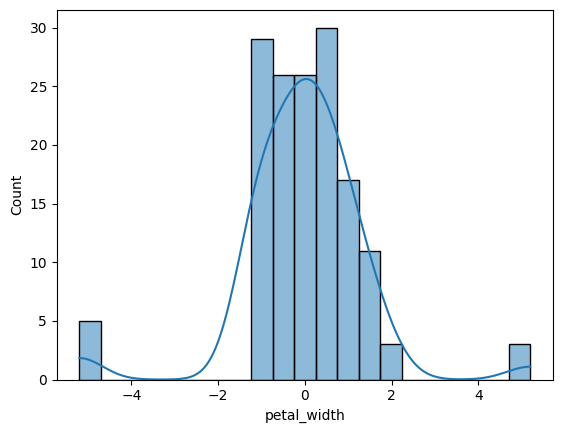

,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.000000,1.000000,1.000000,1.000000
1,KNeighborsClassifier,1.000000,1.000000,1.000000,1.000000
2,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000
3,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000
4,SVC,0.947368,0.941919,0.945597,0.947166


In [54]:

transformer = QuantileTransformer(output_distribution='normal', n_quantiles=100, random_state=0)

# Ajustar y transformar los datos
df_transformed = transformer.fit_transform(df_2)

# Convertir de nuevo a DataFrame para facilitar la visualización
df_transformed = pd.DataFrame(df_transformed, columns=df_2.columns)

X_transformed = df_transformed.drop('target', axis=1)
y = labelEncoder.fit_transform(df_transformed['target'])

sns.histplot(df_transformed['petal_width'], kde=True)
plt.show()
calc_classification_predictions(X_transformed,y)


### Discretización de datos - KbinsDiscretizer

Para realizar este paso será necesario conocer bien nuestro dataset y ver qué datos podemos discretizar, si es que hay algún rango que nos interese crear. 

,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.000000,1.000000,1.000000,1.000000
1,KNeighborsClassifier,1.000000,1.000000,1.000000,1.000000
2,DecisionTreeClassifier,0.947368,0.941919,0.941919,0.947368
3,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000
4,SVC,1.000000,1.000000,1.000000,1.000000


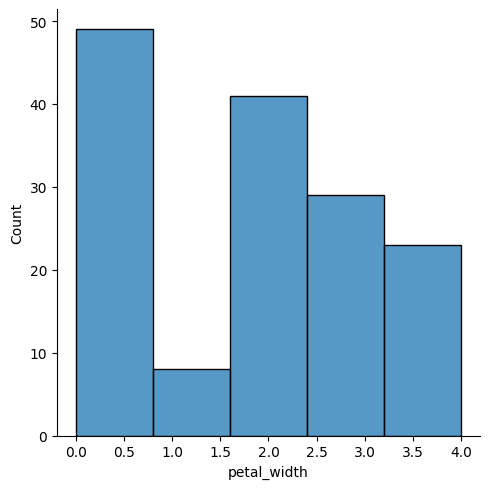

In [58]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

X_discretized = X.copy()

#TODO Seleccionamos la columna que queramos discretizar
column_to_discretize = 'petal_width'

X_discretized[column_to_discretize] = discretizer.fit_transform(X[[column_to_discretize]])

sns.displot(X_discretized[column_to_discretize], bins=5)
calc_classification_predictions(X_discretized,y)

# Modelado y entrenamiento del modelo

En esta fase procedemos directamente a entrenar el modelo teniendo en cuenta los pasos más convenientes. Para ello, utilizaremos un Pipeline de CLASIFICACIÓN.

### 1. Creación de Pipeline de CLASIFICACIÓN

In [26]:

#TODO SELECCIONA la X y la y originales, no vayas a liar un pifostio
label_encoder = LabelEncoder()

df.rename(columns={'species': 'target'}, inplace=True)

X = df.drop(['target'], axis=1)
y = label_encoder.fit_transform(df['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# TODO Aplicar IsolationForest e IQR antes de empezar con el pipeline (si es necesario)
# TODO Aplicar LabelEncoder a la columna categórica
# TODO Aplicar discretizer a la columna que se quiera discretizar antes del pipeline
# TODO En caso de muestras desbalanceadas, utiliza el class_weight='balanced' de algunos modelos

#TODO Definir las columnas categóricas y numéricas
categorical_features = []
numerical_features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Crear el pipeline de preprocesamiento
pipeline_num = Pipeline([
    ('imputer_iterative', IterativeImputer()),
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(k=3)),
    ('pca', PCA(n_components=2)),
    ('quantile_transformer', QuantileTransformer(output_distribution='normal', n_quantiles=100, random_state=0))
])

# columnas categoricas
pipeline_cat = Pipeline([
    ("imputer_constant", SimpleImputer(strategy='most_frequent')),
     ("encoder", OrdinalEncoder()),
    
])


preprocessor = ColumnTransformer([
    ("numeric", pipeline_num, numerical_features ),
    ("categorical", pipeline_cat, categorical_features)
])

preprocessor.fit(X_train, y_train)


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer_iterative',
                                                  IterativeImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('select_kbest',
                                                  SelectKBest(k=3)),
                                                 ('pca', PCA(n_components=2)),
                                                 ('quantile_transformer',
                                                  QuantileTransformer(n_quantiles=100,
                                                                      output_distribution='normal',
                                                                      random_state=0))]),
                                 ['sepal_length', 'sepal_width', 'petal_length',
                                  'petal_width']),
                                ('categorical',
                                 Pipeline(steps=[('imputer_constant',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 [])])

### 2. Métricas de evaluación para el Pipeline de Clasificación

In [27]:
def calc_predictions_pipeline(model, X_train, y_train, X_test, y_test):
    df_results = pd.DataFrame(
        columns=['model_name', 'accuracy', 'precision', 'recall_sensitivity', 'recall_specificity', 'f1'])
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    # classification metrics
    model_name = model.__class__.__name__
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall_sensitivity = recall_score(y_test, y_pred, average='micro')
    recall_specificity = recall_score(y_test, y_pred, pos_label=0, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')


    # guardar resultados
    row = [model_name, accuracy, precision, recall_sensitivity, recall_specificity, f1]
    df_results.loc[len(df_results)] = row
    return df_results

### 3. Evaluamos las métricas de nuestro pipeline

In [72]:
# Transformar los datos de entrenamiento y de prueba
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

df_evaluation = pd.DataFrame(columns=['model_name', 'accuracy', 'precision', 'recall_sensitivity', 'recall_specificity', 'f1'])

#TODO ELEGIR LOS MODELOS QUE SE VAYAN A USAR Y CONCATENARLOS AL FINAL DEL TODO

# Modelo 1: KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_preprocessed, y_train)
knn_eval = calc_predictions_pipeline(knn_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_knn_pred = knn_model.predict(X_test_preprocessed)

# Modelo 2: RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_preprocessed, y_train)
rf_eval = calc_predictions_pipeline(rf_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_rf_pred = pd.DataFrame(rf_model.predict(X_test_preprocessed))

# Modelo 3: DecissionTree 
dt_model = DecisionTreeClassifier(max_depth=2) #TODO Decidir profunidad del arbol
dt_model.fit(X_train_preprocessed, y_train)
dt_eval = calc_predictions_pipeline(dt_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_dt_pred = pd.DataFrame(dt_model.predict(X_test_preprocessed))


# Modelo 4: AdaBoost
ada_model = AdaBoostClassifier(estimator=dt_model, n_estimators=50, learning_rate=1.0)
ada_model.fit(X_train_preprocessed, y_train)
ada_eval = calc_predictions_pipeline(ada_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_ada_pred = pd.DataFrame(ada_model.predict(X_test_preprocessed))


df_evaluation = pd.concat([df_evaluation, knn_eval, rf_eval, dt_eval, ada_eval], axis=0)

df_evaluation

f:\DriveSincro\IA\lenguajes_julio\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
f:\DriveSincro\IA\lenguajes_julio\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
f:\DriveSincro\IA\lenguajes_julio\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
f:\DriveSincro\IA\lenguajes_julio\myenv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

,model_name,accuracy,precision,recall_sensitivity,recall_specificity,f1
0,KNeighborsClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
0,RandomForestClassifier,0.966667,0.966667,0.966667,0.966667,0.966667
0,DecisionTreeClassifier,0.933333,0.933333,0.933333,0.933333,0.933333
0,AdaBoostClassifier,0.900000,0.900000,0.900000,0.900000,0.900000


### 4. Dibujamos los residuos de cada modelo

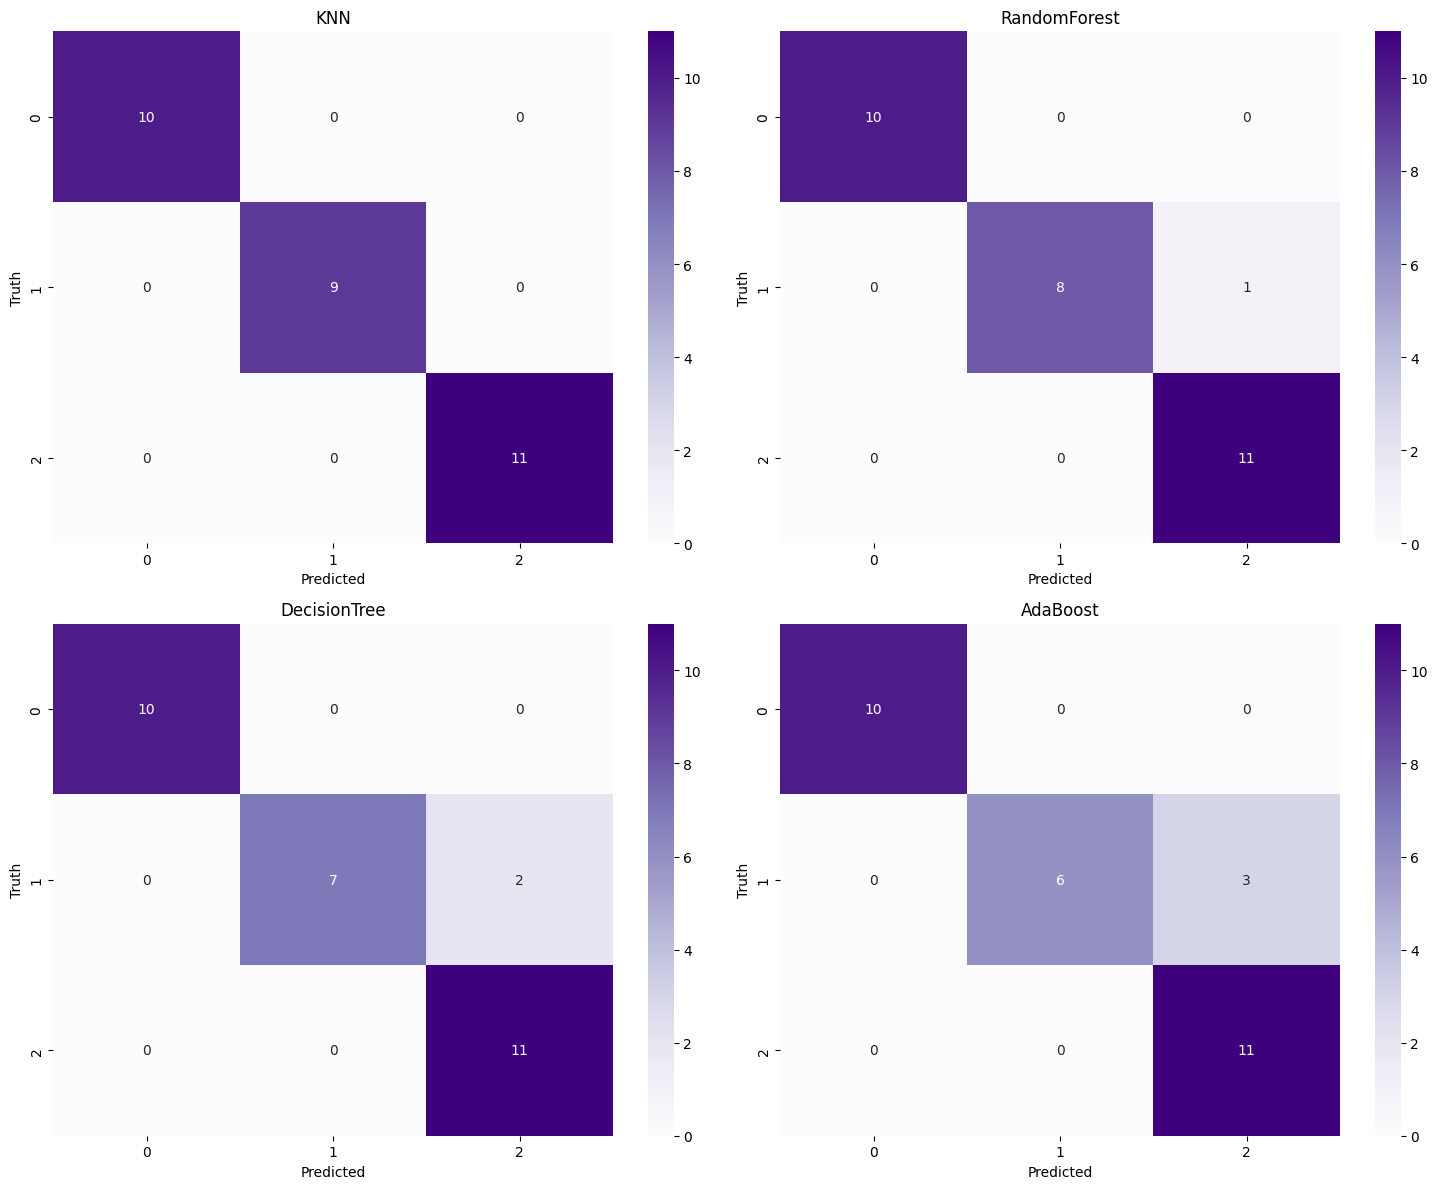

In [77]:
matrix_knn = confusion_matrix(y_test, y_knn_pred)
matrix_rf = confusion_matrix(y_test, y_rf_pred)
matrix_dt = confusion_matrix(y_test, y_dt_pred)
matrix_ada = confusion_matrix(y_test, y_ada_pred)

fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Adjust the size to fit all plots

# Dibujar la matriz de confusión para KNN
sns.heatmap(matrix_knn, annot=True, fmt='d', ax=axs[0][0], cmap='Purples')
axs[0][0].set_xlabel('Predicted')
axs[0][0].set_ylabel('Truth')
axs[0][0].set_title('KNN')

# Dibujar la matriz de confusión para RandomForest
sns.heatmap(matrix_rf, annot=True, fmt='d', ax=axs[0][1], cmap='Purples')
axs[0][1].set_xlabel('Predicted')
axs[0][1].set_ylabel('Truth')
axs[0][1].set_title('RandomForest')

# Dibujar la matriz de confusión para DecisionTree
sns.heatmap(matrix_dt, annot=True, fmt='d', ax=axs[1][0], cmap='Purples')
axs[1][0].set_xlabel('Predicted')
axs[1][0].set_ylabel('Truth')
axs[1][0].set_title('DecisionTree')

# Dibujar la matriz de confusión para AdaBoost
sns.heatmap(matrix_ada, annot=True, fmt='d', ax=axs[1][1], cmap='Purples')
axs[1][1].set_xlabel('Predicted')
axs[1][1].set_ylabel('Truth')
axs[1][1].set_title('AdaBoost')

plt.tight_layout()
plt.show()

### 4. Simulamos una predicción con datos sintéticos

In [47]:

#! PLANTEARSE ELIMINAR ESTA PARTE DEL CÓDIGO

# Datos sintéticos para una predicción
X_new = pd.DataFrame({
    'sepal_length': [5, 5, 4, 7, 5],
    'sepal_width': [3, 2, 3, 3, 3],
    'petal_length': [1, 5, 1, 2, 1],
    'petal_width': [0, 1, 0, 1, 0]
})

# Preprocesar los nuevos datos
X_new_preprocessed = preprocessor.transform(X_new)

# Generar predicciones para cada modelo
predicciones = pd.DataFrame({
    'pred_knn': knn_model.predict(X_new_preprocessed),
    'pred_rf': rf_model.predict(X_new_preprocessed),
    'pred_svc': svc_model.predict(X_new_preprocessed)
})

# Revertir la codificación de las predicciones (asegúrate de tener un codificador definido)
for i in predicciones:
    predicciones[i] = label_encoder.inverse_transform(predicciones[i])

predicciones



,pred_knn,pred_rf,pred_svc
0,setosa,setosa,setosa
1,versicolor,versicolor,versicolor
2,setosa,setosa,setosa
3,setosa,versicolor,setosa
4,setosa,setosa,setosa


## Keras y clasificación multiclase

Para utilizar una red neuronal, sigue los siguientes pasos:
1. Crea el modelo con Keras usando su arquitectura.
2. Compila el modelo -model.compile.
3. Entreanmiento -model.fit
4. Observa lo que haya salido del modelo: model.sumary()
5. Pintar el error -sns.lineplot()
6. Evaluación del modelo
7. Realiza predicciones.

In [48]:
kr = tf.keras

keras_model_clas = kr.Sequential([
     kr.layers.Dense(10, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(3, activation='softmax') #!En la capa de salida preocúpate de que el número de neuronas sea igual al número de clases
])

# Antes de usar Keras, hay que asegurarnos de que los datos tienen cierta forma en la entrada
X_train.shape

(120, 4)

In [49]:
keras_model_clas.compile(optimizer=kr.optimizers.Adam(learning_rate=0.01),
              loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [50]:
keras_model_clas.fit(X_train_preprocessed, y_train, epochs=100, validation_split=0.2)

Epoch 1/100


f:\DriveSincro\IA\lenguajes_julio\myenv\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.3229 - loss: 1.0971 - val_accuracy: 0.2917 - val_loss: 1.0770
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3841 - loss: 1.0688 - val_accuracy: 0.2917 - val_loss: 1.0355
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3477 - loss: 1.0356 - val_accuracy: 0.4167 - val_loss: 0.9663
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6602 - loss: 0.9805 - val_accuracy: 0.4583 - val_loss: 0.9110
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6862 - loss: 0.9259 - val_accuracy: 0.4583 - val_loss: 0.8679
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6836 - loss: 0.8594 - val_accuracy: 0.8750 - val_loss: 0.8325
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7448 - loss: 0.8206 - val_accuracy: 0.6667 - val_loss: 0.7674
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6432 - loss: 0.7816 - val_accuracy: 0.6667 - val_loss: 0.6959
Epo

## Evaluación

In [51]:

kr.utils.plot_model(keras_model_clas, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [52]:
keras_model_clas.history.history

{'accuracy': [0.3333333432674408,
  0.3541666567325592,
  0.375,
  0.6875,
  0.7083333134651184,
  0.6875,
  0.7395833134651184,
  0.6458333134651184,
  0.65625,
  0.6770833134651184,
  0.6875,
  0.6875,
  0.6979166865348816,
  0.6979166865348816,
  0.71875,
  0.71875,
  0.7291666865348816,
  0.75,
  0.78125,
  0.78125,
  0.78125,
  0.8229166865348816,
  0.8541666865348816,
  0.8541666865348816,
  0.8541666865348816,
  0.8854166865348816,
  0.8854166865348816,
  0.875,
  0.8958333134651184,
  0.8958333134651184,
  0.8958333134651184,
  0.90625,
  0.90625,
  0.90625,
  0.90625,
  0.9270833134651184,
  0.9375,
  0.9375,
  0.9375,
  0.9375,
  0.9375,
  0.9375,
  0.9375,
  0.9375,
  0.9479166865348816,
  0.9479166865348816,
  0.9375,
  0.9479166865348816,
  0.9583333134651184,
  0.9479166865348816,
  0.9479166865348816,
  0.9479166865348816,
  0.9479166865348816,
  0.9479166865348816,
  0.9479166865348816,
  0.9479166865348816,
  0.9583333134651184,
  0.9479166865348816,
  0.95833331346511

<Axes: >

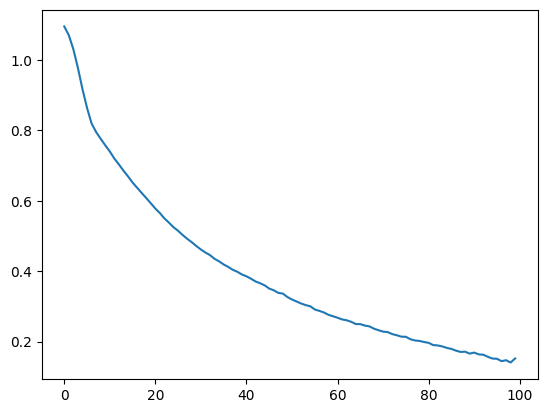

In [53]:
mse = keras_model_clas.history.history['loss']
sns.lineplot(x=range(len(mse)), y=mse)

In [54]:
training_score = keras_model_clas.evaluate(X_train_preprocessed, y_train)
test_score = keras_model_clas.evaluate(X_test_preprocessed, y_test)

print(keras_model_clas.metrics_names)
print('training_score', training_score)
print('test_score', test_score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9846 - loss: 0.1464 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.1028
['loss', 'compile_metrics']
training_score [0.1738164871931076, 0.9666666388511658]
test_score [0.1028352826833725, 1.0]


In [55]:
y_pred = keras_model_clas.predict(X_test_preprocessed)
y_pred = np.argmax(y_pred, axis=-1) #La predicción genera distintos pesos que suman 1, con esto se queda simplificado a un array
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0], dtype=int64)

In [56]:

df_results = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred.ravel()
})
df_results.head()

,y_test,y_pred
0,1,1
1,0,0
2,2,2
3,1,1
4,1,1


### Mostrar predicciones (matriz de confusión)

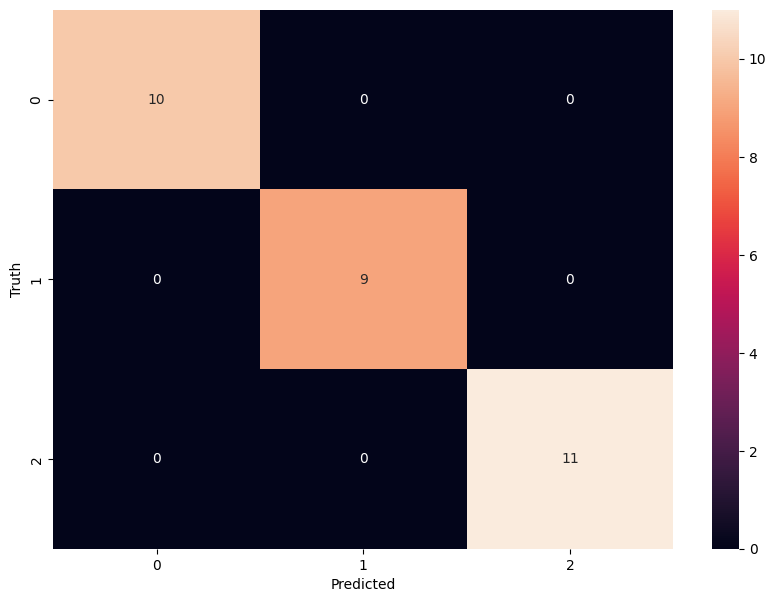

In [57]:

#TODO PINTAMOS UNA MATRIZ DE CONFUSIÓN

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Dibujar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()